Make sure that you have all libraries installed via `pip`

`scikit-learn==0.17.1
toolz==0.7.4
pandas==0.16.2
matplotlib==1.5.1
numpy==1.10.4
spark-sklearn==0.1.2
ipython==4.0.3`

In [4]:
import pandas as pd
import numpy as np
from time import time
from toolz import valmap
import sklearn as sk
import sklearn.ensemble as skes
import sklearn.pipeline as skpipe
import spark_sklearn as spark_sk
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')

# First adventure in Scikit-Learn

**Available on:** `https://github.com/liabifano/courses/meetups/grupy`

**email**: `liabifano@gmail.com`

### What are we gonna see today?
A practical example of scikit-learn usage step-by-step in a real dataset.

### Sklearn starts to help just after...
- problem is well defined and you already know what you have to predict
- you have a nice dataset to work with (treated features and lack of consistency issues)

# Data Overview 

### Santander Customer Satisfaction
Try to predict if a customer is unhappy with Santander's Customer Service.

So based in a sample of 76020 clients, Santander would like to know which other clients in their portifolio is `unhappy` to call and offer "exclusive rates `(?)`"

**Target:** `TARGET` column in the dataset has 0-`happy` and 1-`unhappy`

**Features:** `369` columns with information of account and client profile

This data is available in `kaggle` website: `www.kaggle.com/c/santander-customer-satisfaction`

In [6]:
data_all = pd.read_csv('/Users/lia.bifano/personal/courses/meetups/grupy/santander_train.csv')
all_features = data_all.columns - ['ID','TARGET']
print 'All dataset has: %d columns and %d rows' %(data_all.shape[1], data_all.shape[0])

All dataset has: 371 columns and 76020 rows


# 1. Split Dataset
Separate your original dataset in to order to evaluate your model(s) and make sure that it generalizes for all clients.

There are many ways to split the datasets and the choice of a split strategy depends on the problem at hand.

The simplest way is a random split with just 2 datasets `{train/test}`, so we are gonna estimate the model in the **train set** and validate it in the **test set **(the "truth") as the example below:

In [7]:
test_size_prop=0.3
data_train, data_test = sk.cross_validation.train_test_split(data_all, test_size=test_size_prop, random_state=1234)

all_features = data_all.columns - ['ID','TARGET']
X_train, y_train = data_train[all_features], data_train['TARGET']
X_test, y_test = data_test[all_features], data_test['TARGET']

**After this step we should explore our train dataset:**
- understanding the meaning of each variable and interactions
- checking outliers and missing values to see if they are reasonable and thinking about method to deal with this issues
- thinking about the business and come up with new variables that could be useful (feature engineering step)

however this sklearn it is not so helpful in this stage and it not in this presentation scope

# 2. Feature Selection

Not all features in our dataset can really add value in the model and remove them can help us. For instance, probabily the client's eyes color do not tell us nothing about if his is `happy` about Santander's Service and keep this variable might turn the model:
- more complicated than it should
- increase the running time
- increase instability 

Some methods to select our features are: `anova-f` value, boruta*, lasso, random forest, stepwise for linear models, etc

`(*) sklearn still do not have it implemented`

The example below show `anova-f` selection:

$H_{0}:$ the mean in both group is equal {`happy`,`unhappy`}

`p-value`: considering that $H_0$ is true, what is the probability to see what I saw? So low values means that this variable might be good in the model.

In [8]:
function_rule_selection = sk.feature_selection.f_classif
alpha_cutoff = 0.01

selection_rule = sk.feature_selection.SelectFdr(function_rule_selection, alpha_cutoff)
selection_rule.fit(X_train.values, y_train.values);

Were selected 113 variables from 369, (30.6 %)


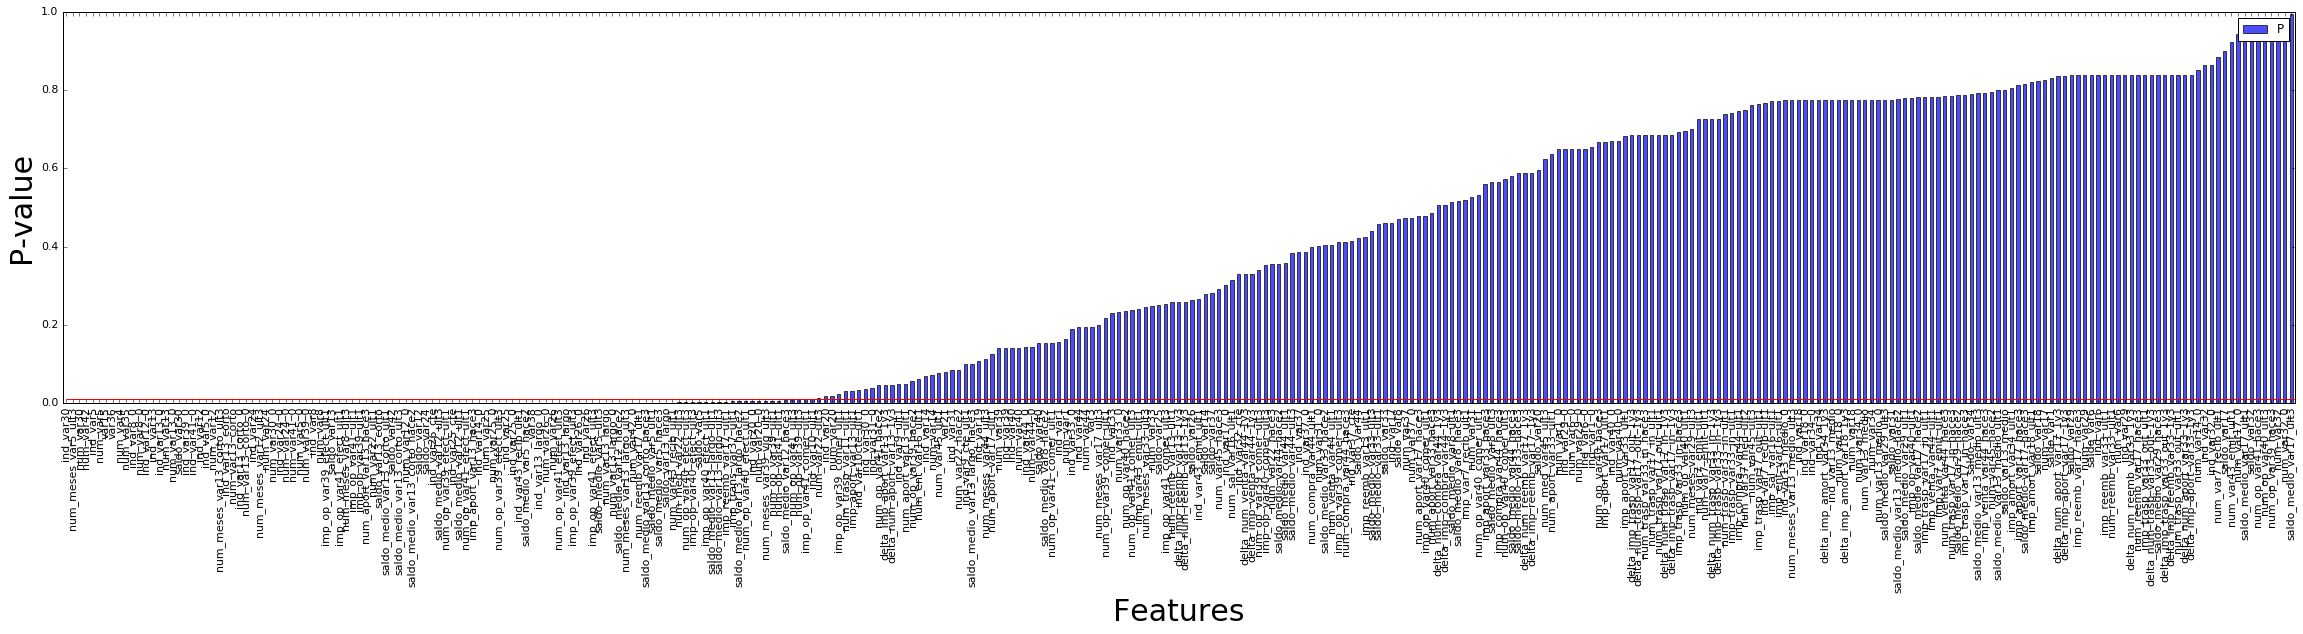

In [9]:
all_pvalues = filter(lambda x: pd.notnull(x[0]), zip(selection_rule.pvalues_, all_features))
filtered_pvalues = filter(lambda x: x[0]<=alpha_cutoff, all_pvalues)
all_select_features = map(lambda x: x[1], filtered_pvalues)

print 'Were selected %d variables from %d, (%.1f %%)' %(len(all_select_features), 
                                                        len(all_features), 
                                                        len(filtered_pvalues)*100/float(len(all_features)))

(pd.DataFrame(all_pvalues)
 .set_index(1)
 .sort(0)
 .plot(kind='bar', figsize=(40,7), fontsize=11, alpha=0.7, color='blue'));
plt.xlabel('Features', fontsize=30); plt.ylabel('P-value', fontsize=30); plt.legend('Pvalue');
plt.hlines(y=0.01, xmin=0, xmax=len(all_features), color='red');

This method do not consider multivariate interactions because calculate the p-value just based in the interaction between the target and a single feature and it might result in an even smaller feature subset.

# 3. Preprocessing

- Input valid values for missing values
- Normalize the features (transform every feature in order to have the same scale, for some models it is crucial to avoid unstable solutions and ill-conditioned matrix)

The code below show how to compute and apply the median for missing values:

In [10]:
imput_method = sk.preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)

X_all_train_imputed = imput_method.fit_transform(X_train.values)
X_all_test_imputed = imput_method.transform(X_test.values)

X_select_train_imputed = imput_method.fit_transform(X_train[all_select_features].values)
X_select_test_imputed = imput_method.transform(X_test[all_select_features].values)

# Model(s) Estimation in Train and Prediction in Test 

In [11]:
start = time()
rf = skes.RandomForestClassifier(n_estimators=100)
rf.fit(X_select_train_imputed, y_train.values)

predicted_rf_test = rf.predict(X_select_test_imputed)
print 'Running time: %ds' %(time()-start)

Running time: 17s


Every model is a class and have the methods `.fit` and `.predict`, so this standard allow us to run any model with same interface, like the example below:

`ps:` be carefull because the method `.fit` transform the object

In [18]:
start = time()

models_default = {'ridge': sk.linear_model.RidgeClassifier(), 
                  'rf'   : skes.RandomForestClassifier(n_estimators=100, random_state=1), 
                  'et'   : skes.ExtraTreesClassifier(n_estimators=100, random_state=1)}

valmap(lambda model: model.fit(X_select_train_imputed, y_train), models_default);
print 'Running time: %ds' %(time()-start)

predictions_default_in_test = valmap(lambda model: model.predict(X_select_test_imputed), models_default);

Running time: 28s


# Model(s) Validation

The module `metris` in sklearn has a huge set of metrics to evaluate the models, it receives 2 args, one is the true value observed in the data and the other is the estimated value.

One common used metric for classification problems is `AUC - Area under Curve (ROC)` that is a metric that takes in consideration false positives rate and true positive rate.

<img src="roc.jpg" style="width: 300px;" />

AUC around 0.5 is the same that flip a coin rule and close to 1 means a very powerful model to predict the change of right classification.

In [19]:
evaluated_models = valmap(lambda prediction: sk.metrics.roc_auc_score(y_test, prediction), predictions_default_in_test)
pd.DataFrame(evaluated_models.values(), index=evaluated_models.keys()).rename(columns={0:'AUC'}).sort()

,AUC
et,0.526907
rf,0.524702
ridge,0.500000


### Can we do better?
- try different set of features
- work with more powerful models
- tuning hyperparameters (*)
- do ensemble or stacking

# Can we do better? 

As example, considere `ridge` model, it has some hyperparameters that can be changed in order to get a higher performance. In the example above it was not considered to run a model, however it is a crucial aspect to improve the model performance.

In [20]:
models_default['ridge']

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001)

There are few way to find which are the best hyperparameters, such as:
- Grid Search (`GridSearchCV method`)
- Random Search (`RandomizedSearchCV method`)

And the way that it works is: run the model with a set of parameters and compare the performance based in cross-validation. Let's take the `ridge` example and use a grid search.

In [21]:
start = time()

search_space_ridge = {'alpha'        : [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 3, 4], 
                      'normalize'    : [True, False], 
                      'fit_intercept': [True, False]}

search_best_ridge = sk.grid_search.GridSearchCV(models_default['ridge'], search_space_ridge);
search_best_ridge.fit(X_select_train_imputed, y_train);

print 'Running time: %ds' %(time()-start)
print 'The best parameters for this model is: %s' %search_best_ridge.best_params_

Running time: 34s
The best parameters for this model is: {'normalize': True, 'alpha': 0.5, 'fit_intercept': True}


Note that it is flexible to receive any model. So it is possible build a map of searching spaces and models and then put the machine to work until tomorrow!

However tomorrow is a little far away...

...and the example above is very silly because it is a small dataset, a simple model and a very restricted set of hyperparameters (`just 10 combinations`). In the real world it is much more complicated and most of time this do not solve our problems...

To try make it more reasonable we can use `hyperopt` and `spark_learn` which intregates very well with sklearn and runs parallel optimization.

In [22]:
start = time()

search_best_ridge_spark = spark_sk.GridSearchCV(sc, models_default['ridge'], search_space_ridge)
search_best_ridge_spark.fit(X_select_train_imputed, y_train);

print 'Running time: %ds' %(time()-start)
print 'The best parameters for this model is: %s' %search_best_ridge_spark.best_params_

Running time: 27s
The best parameters for this model is: {'normalize': True, 'alpha': 0.5, 'fit_intercept': True}


It is not so efficient because it is a small set of hyperparameters and the latency time has impact, besides that, it is running in just one machine.